## Task 2 - Assignment 3
## Sujai Rajan
## CS 6140

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import cross_val_score, KFold, train_test_split


class SVM:
    
    def _rbf_kernel(self, X_t, X):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X_t[:, np.newaxis] - X[np.newaxis, :], axis=2) ** 2)

    def _polynomial_kernel(self, X_t, X):
        return (X_t.dot(X.T)) ** self.degree

    def _linear_kernel(self, X, X_t):
        return (X.dot(X_t.T))

    def _exponential_kernel(self, X_t, X):
        return np.exp(-np.linalg.norm(X_t[:, np.newaxis] - X[np.newaxis, :], axis=2) / (2 * self.sigma ** 2))

    def _laplacian_kernel(self, X_t, X):
        return np.exp(-np.linalg.norm(X_t[:, np.newaxis] - X[np.newaxis, :], axis=2) / self.sigma)

    def _sigmoid_kernel(self, X_t, X):
        return np.tanh(self.sigma * X_t.dot(X.T) + self.c)
    
    
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.C = 1
            self.degree = degree
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.sigma = sigma
        elif kernel == 'exponential':
            self.kernel = self._exponential_kernel
            self.sigma = sigma
        elif kernel == 'laplacian':
            self.kernel = self._laplacian_kernel
            self.sigma = sigma
        elif kernel == 'sigmoid':
            self.kernel = self._sigmoid_kernel
            self.sigma = sigma
            self.degree = degree
        else:
            self.kernel = self._linear_kernel

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None


    def fit(self, X, y, lr=1e-3, epochs=200):
        self.X = X
        self.y = y
        self.alpha = np.ones(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0])
        gains = []
        y_outer = np.outer(y, y)
        y_iy_jk_ij = y_outer * self.kernel(X, X)

        for _ in range(epochs):
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)
            self.alpha = self.alpha + lr * gradient
            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0
            gain = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            gains.append(gain)

        index = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        self.b = np.mean(b_i)
        plt.plot(gains)
        plt.title("loss per epochs")
        plt.show()

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return accuracy_score(y, y_hat)

    def evaluate(self, X, y):
        y_hat = self.predict(X)
        accuracy = accuracy_score(y, y_hat)
        return accuracy

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired,
        alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)
        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
        linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])
        # highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.],
        s=50,
        linewidth=1, facecolors='none', edgecolors='k')
        plt.show()     
        
def k_fold_evaluation(X, y, k=5,C=1.0, kernel='rbf', sigma=0.1,epochs =200):
    kf = KFold(n_splits=k)
    test_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        svm = SVM(C=C, kernel=kernel, sigma=sigma)  # Create SVM instance
        svm.fit(X_train, y_train, lr=1e-3, epochs=epochs)  # Train SVM on the training set

        test_score = svm.score(X_test, y_test)  # Evaluate SVM on the test set
        test_scores.append(test_score)

    mean_test_score = np.mean(test_scores)
    print("Mean Test Score: %.4f" % mean_test_score)

        
def custom_kernel(kernel_name, sigma):
    def exponential_kernel(X, Y):
        return np.exp(-np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2) / (2 * sigma ** 2))

    def laplacian_kernel(X, Y):
        return np.exp(-np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2) / sigma)

    if kernel_name == 'exponential':
        return exponential_kernel
    elif kernel_name == 'laplacian':
        return laplacian_kernel

        

def find_best_kernel(X, y, kernels, sigma):
    best_kernel = None
    best_accuracy = 0.0

    for kernel in kernels:
        if kernel == 'exponential' or kernel == 'laplacian':
            svm = SVC(kernel=custom_kernel(kernel, sigma))
        else:
            svm = SVC(kernel=kernel)
        scores = cross_val_score(svm, X, y, cv=5)
        accuracy = np.mean(scores)
        print(f"Kernel: {kernel}, Accuracy: {accuracy:.2f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kernel = kernel

    print(f"\nBest Kernel: {best_kernel}, Accuracy: {best_accuracy:.2f}")

    return best_kernel




class SampleData:
    def get_half_circles(self, n_samples, noise=0.05, factor=0.5, random_state=None):
        half_circles = make_circles(n_samples=n_samples, noise=noise, factor=factor, random_state=random_state)
        X = half_circles[0]
        y = half_circles[1]
        y[y == 0] = -1
        return X, y

    def get_moons(self, n_samples, noise=0.05, random_state=None):
        moons = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
        X = moons[0]
        y = moons[1]
        y[y == 0] = -1
        return X, y

    def visualize_dataset(self, X, y, title):
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
        plt.title(title)
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.show()

    def visualize_decision_boundary(self, X, y, model, title):
        h = 0.02  # step size in the mesh
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.title(title)
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.show()
        
    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.show()        

In [2]:
# Generate the half-circles dataset
sample = SampleData()
X_half_circles, y_half_circles = sample.get_half_circles(n_samples=1001, noise=0.05, factor=0.5)
X_train_half_circles, X_test_half_circles,y_train_half_circles, y_test_half_circles = train_test_split(X_half_circles, y_half_circles, test_size =0.3, random_state=1)

# Find the best kernel function for the half-circles dataset
kernels = ['linear', 'poly', 'rbf', 'sigmoid','exponential','laplacian']
best_kernel_half_circles = find_best_kernel(X_half_circles, y_half_circles, kernels, sigma = 1)

Kernel: linear, Accuracy: 0.55
Kernel: poly, Accuracy: 0.69
Kernel: rbf, Accuracy: 1.00
Kernel: sigmoid, Accuracy: 0.54
Kernel: exponential, Accuracy: 1.00
Kernel: laplacian, Accuracy: 1.00

Best Kernel: rbf, Accuracy: 1.00


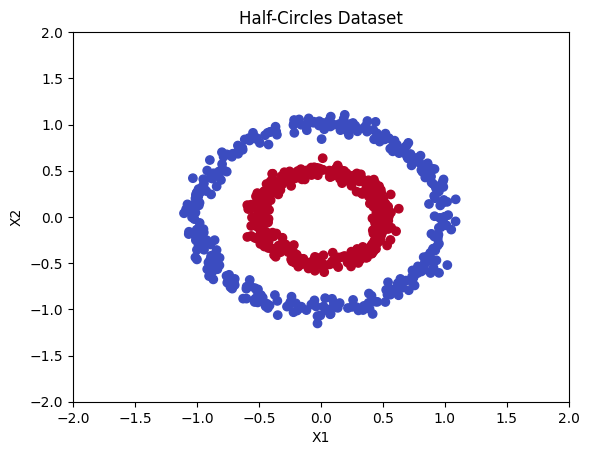

In [3]:
# Visualize the half-circles dataset
sample.visualize_dataset(X_train_half_circles, y_train_half_circles, "Half-Circles Dataset")

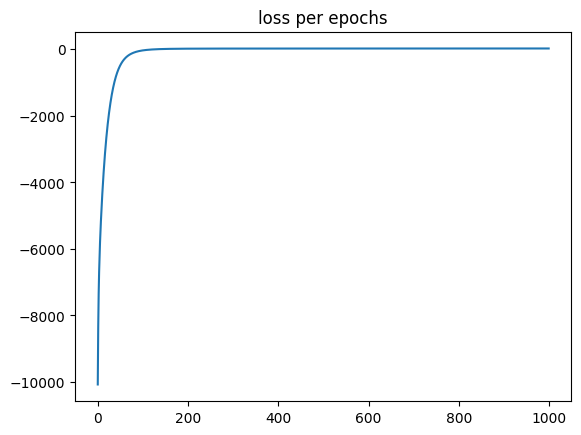

In [4]:
# Train SVM model with the best kernel on the half-circles dataset
svm_half_circles_best = SVM(C=5.0, kernel=best_kernel_half_circles, sigma = 1)
svm_half_circles_best.fit(X_train_half_circles, y_train_half_circles, lr=1e-3 , epochs = 1000)

Half Circles - Train score: 1.0


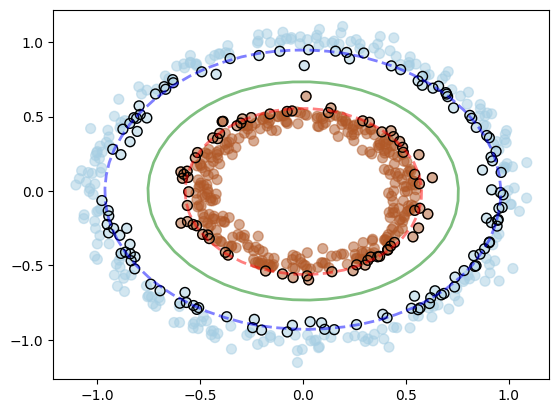

Half Circles - Test score: 1.0


In [5]:
print("Half Circles - Train score:", svm_half_circles_best.score(X_train_half_circles, y_train_half_circles))
svm_half_circles_best.plot_decision_boundary()
print("Half Circles - Test score:", svm_half_circles_best.score(X_test_half_circles, y_test_half_circles))

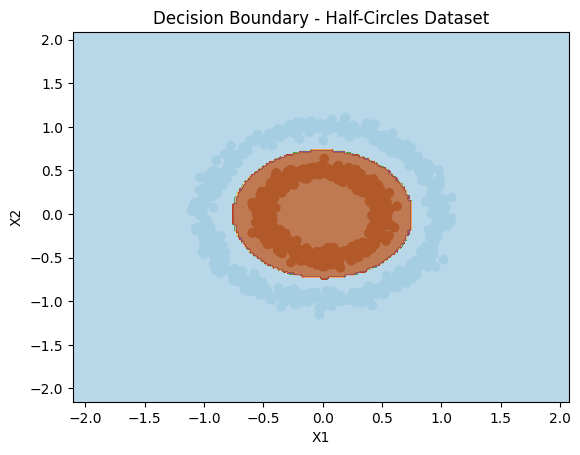

In [6]:
# Visualize the decision boundary for the best kernel on the half-circles dataset
sample.visualize_decision_boundary(X_half_circles, y_half_circles, svm_half_circles_best, "Decision Boundary - Half-Circles Dataset")

In [7]:
y_pred_half_circles = svm_half_circles_best.predict(X_half_circles)
print(confusion_matrix(y_half_circles,y_pred_half_circles))
print(classification_report(y_half_circles, y_pred_half_circles))

[[500   0]
 [  0 501]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       501

    accuracy                           1.00      1001
   macro avg       1.00      1.00      1.00      1001
weighted avg       1.00      1.00      1.00      1001



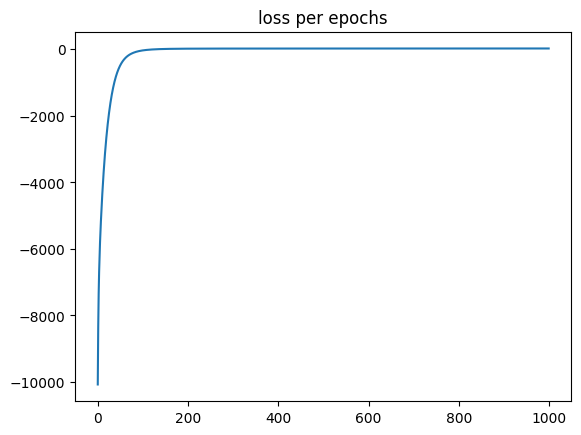

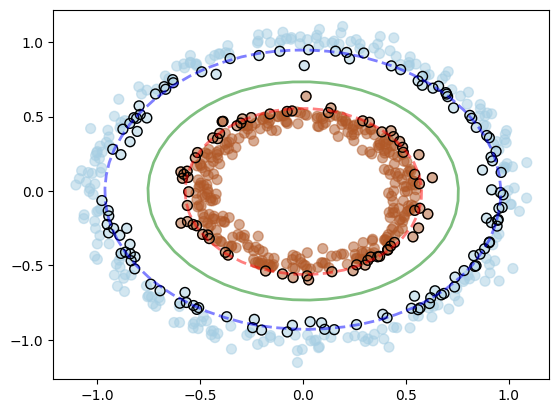

In [8]:
best_kernel_moons = 'exponential'
# Train SVM model with the best kernel on the half-circles dataset with exponential
svm_half_circles_best = SVM(C=5.0, kernel=best_kernel_half_circles, sigma = 1)
svm_half_circles_best.fit(X_train_half_circles, y_train_half_circles, lr=1e-3 , epochs = 1000)
svm_half_circles_best.plot_decision_boundary()


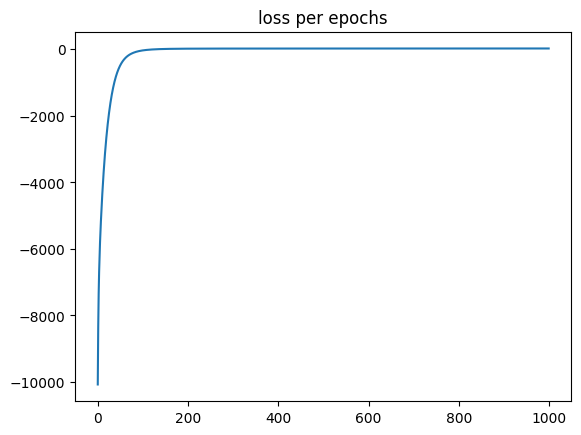

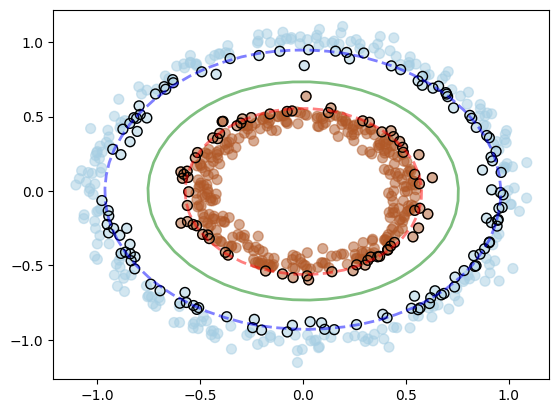

In [9]:
best_kernel_moons = 'laplacian'
# Train SVM model with the best kernel on the half-circles dataset with laplacian
svm_half_circles_best = SVM(C=5.0, kernel=best_kernel_half_circles, sigma = 1)
svm_half_circles_best.fit(X_train_half_circles, y_train_half_circles, lr=1e-3 , epochs = 1000)
svm_half_circles_best.plot_decision_boundary()

In [10]:
# Generate the moons dataset
X_moons, y_moons = sample.get_moons(n_samples=1001, noise=0.05)
X_train_moons, X_test_moons,y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, test_size =0.3, random_state=1)

# Find the best kernel function for the moons dataset
best_kernel_moons = find_best_kernel(X_moons, y_moons, kernels, sigma = 0.5)

Kernel: linear, Accuracy: 0.88
Kernel: poly, Accuracy: 0.94
Kernel: rbf, Accuracy: 1.00
Kernel: sigmoid, Accuracy: 0.63
Kernel: exponential, Accuracy: 1.00
Kernel: laplacian, Accuracy: 1.00

Best Kernel: rbf, Accuracy: 1.00


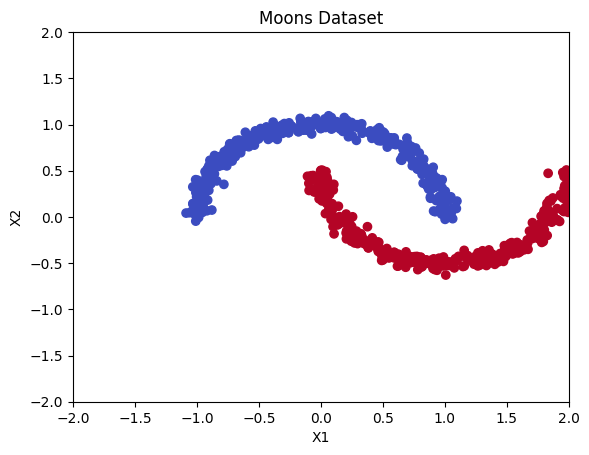

In [11]:
# Visualize the moons dataset
sample.visualize_dataset(X_train_moons, y_train_moons, "Moons Dataset")

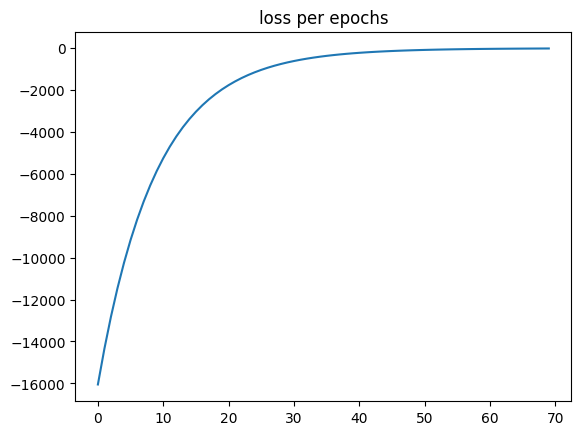

In [12]:
# Train SVM model with the best kernel on the moons dataset
svm_moons_best = SVM(C=1.0, kernel=best_kernel_moons, sigma =.3)
svm_moons_best.fit(X_train_moons, y_train_moons, lr =0.001, epochs = 70)

Moons - Train score: 1.0


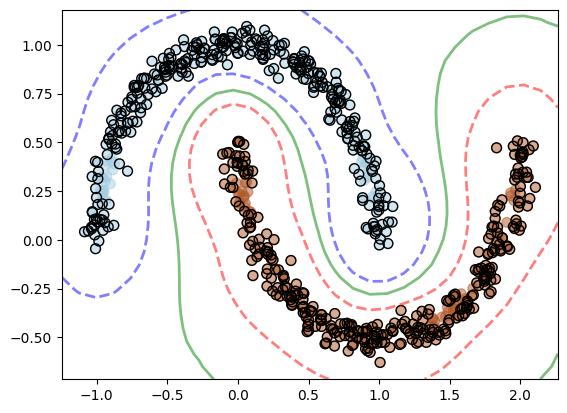

Moons - Test score: 1.0


In [13]:
print("Moons - Train score:", svm_moons_best.score(X_train_moons, y_train_moons))
svm_moons_best.plot_decision_boundary()
print("Moons - Test score:", svm_moons_best.score(X_test_moons, y_test_moons))

In [14]:
y_pred_moons = svm_moons_best.predict(X_moons)
print(confusion_matrix(y_moons,y_pred_moons))
print(classification_report(y_moons, y_pred_moons))

[[500   0]
 [  0 501]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       501

    accuracy                           1.00      1001
   macro avg       1.00      1.00      1.00      1001
weighted avg       1.00      1.00      1.00      1001



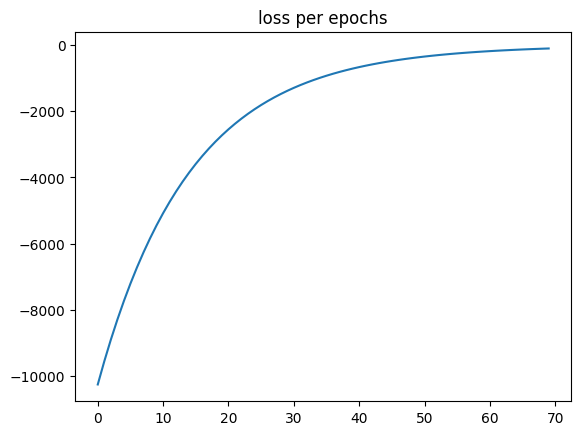

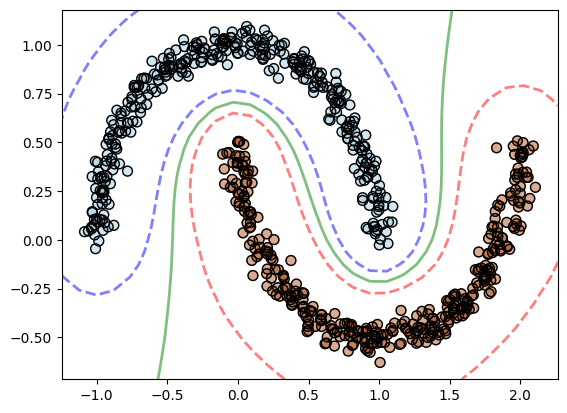

In [15]:
best_kernel_moons = 'exponential'
# Train SVM model with the best kernel on the moons dataset with exponential
svm_moons_best = SVM(C=1.0, kernel=best_kernel_moons, sigma =.3)
svm_moons_best.fit(X_train_moons, y_train_moons, lr =0.001, epochs = 70)
svm_moons_best.plot_decision_boundary()

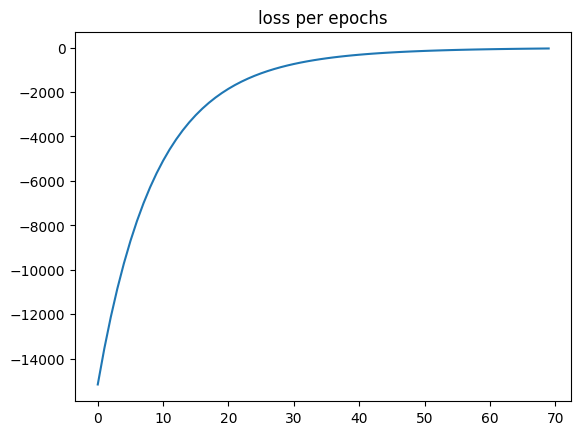

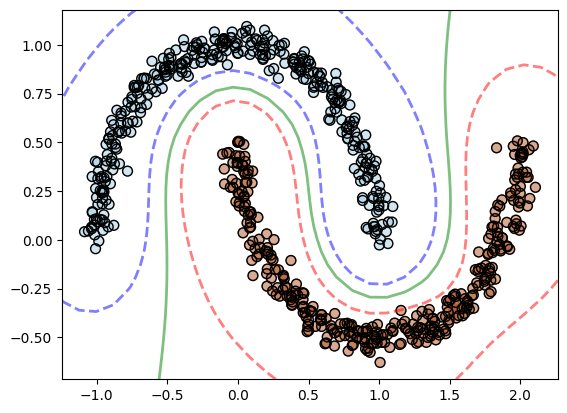

In [16]:
best_kernel_moons = 'laplacian'
# Train SVM model with the best kernel on the moons dataset with laplacian
svm_moons_best = SVM(C=1.0, kernel=best_kernel_moons, sigma =.3)
svm_moons_best.fit(X_train_moons, y_train_moons, lr =0.001, epochs = 70)
svm_moons_best.plot_decision_boundary()

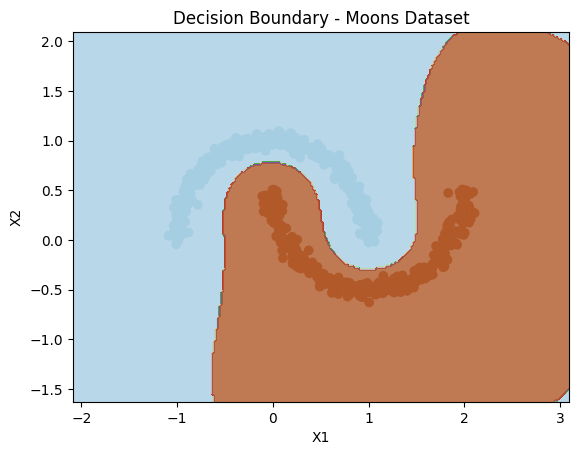

In [17]:
# Visualize the decision boundary for the best kernel on the moons dataset
sample.visualize_decision_boundary(X_train_moons, y_train_moons, svm_moons_best, "Decision Boundary - Moons Dataset")

k-fold cross-validation on the half-circles dataset


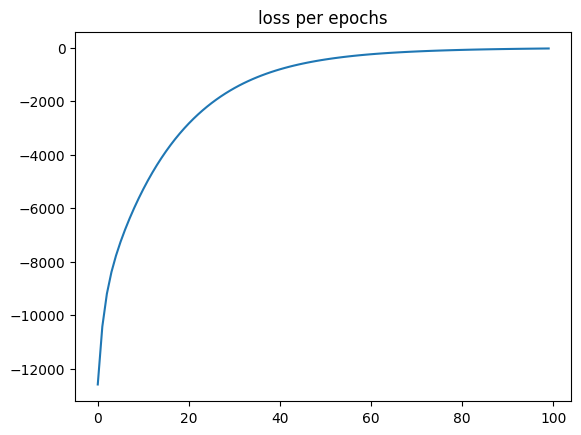

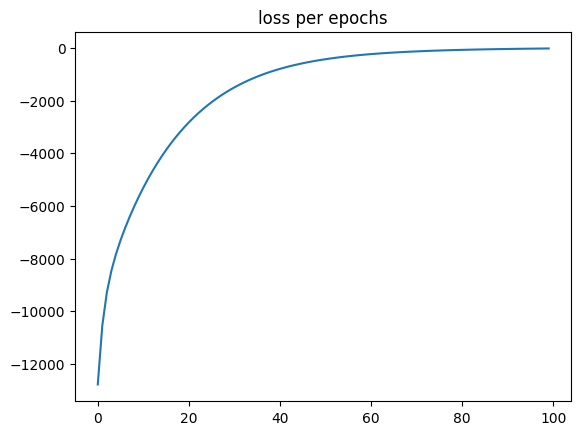

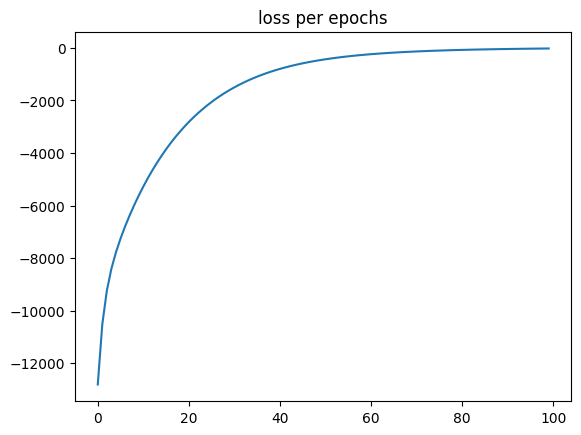

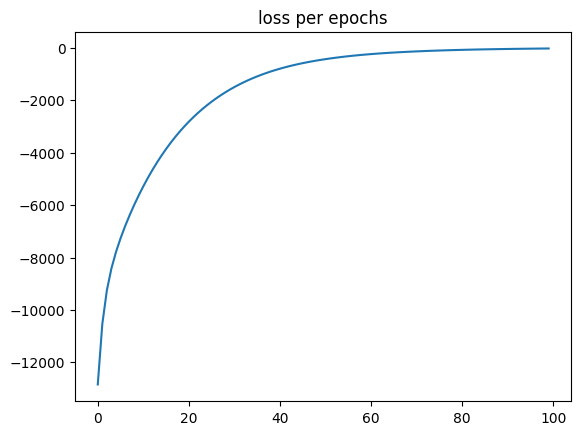

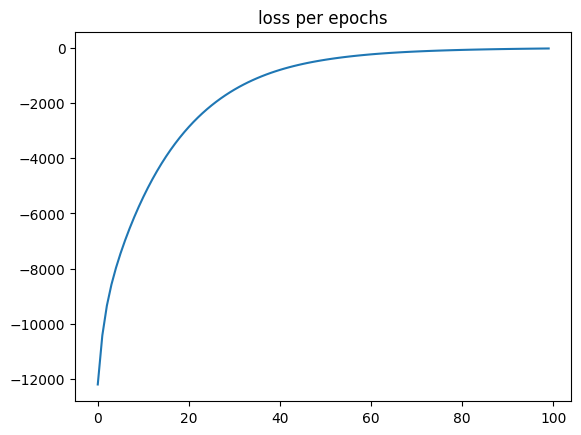

Mean Test Score: 1.0000


In [18]:
# Perform k-fold cross-validation on the half-circles dataset
print('k-fold cross-validation on the half-circles dataset')
k_fold_evaluation(X_half_circles, y_half_circles, k=5, C=5.0, kernel='rbf', sigma=1,epochs = 100)

k-fold cross-validation on the moons dataset


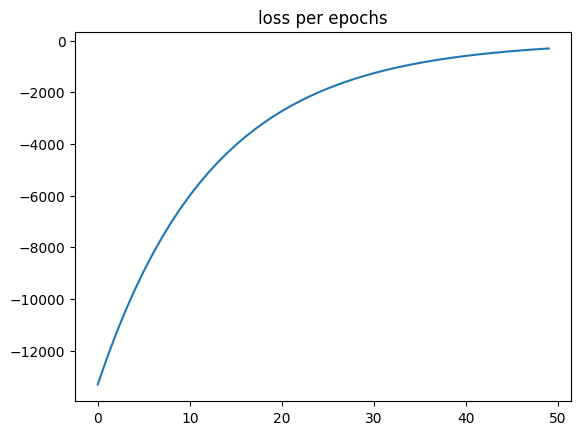

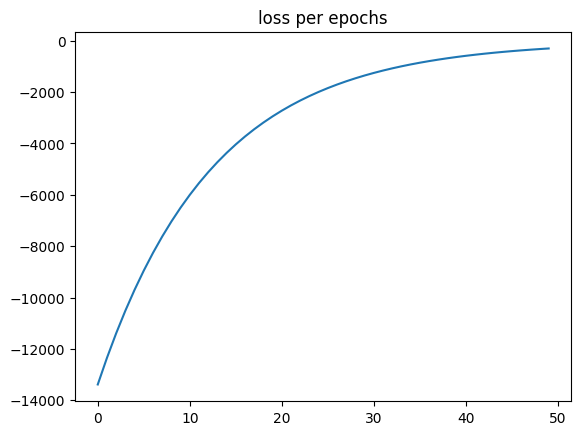

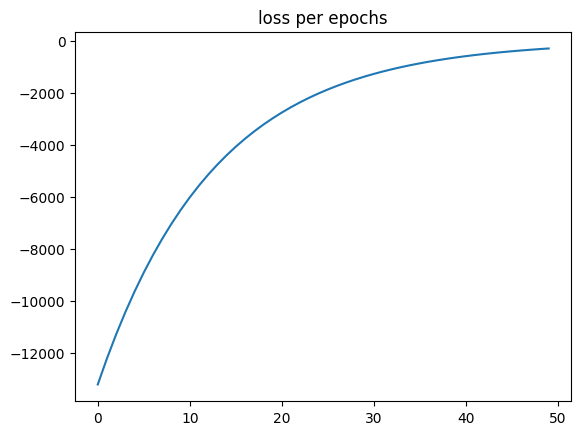

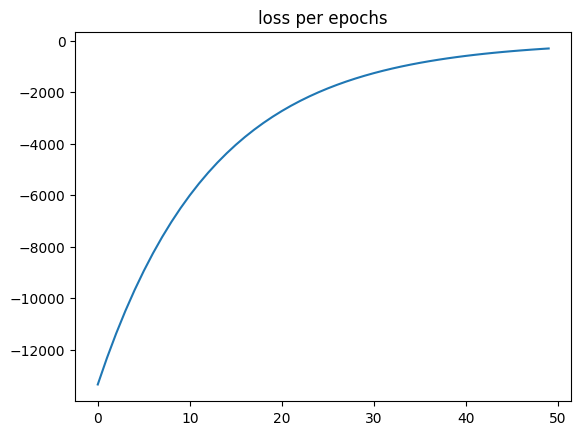

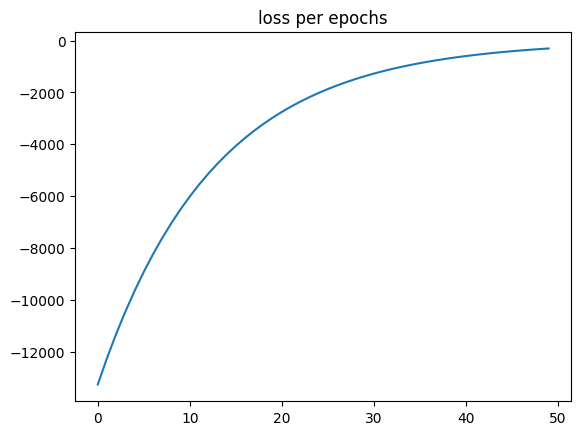

Mean Test Score: 1.0000


In [19]:
# Perform k-fold cross-validation on the moons dataset
print('k-fold cross-validation on the moons dataset')
k_fold_evaluation(X_moons, y_moons, k=5, C=1.0, kernel='exponential', sigma=0.3,epochs = 50)

## For the half-circles dataset:
The best kernel function is rbf (radial basis function) with an accuracy of 1.00. This indicates that the SVM model with the rbf kernel achieved perfect classification on the training set.

## For the moons dataset:
The best kernel function is also rbf with an accuracy of 1.00. The Laplacian and Exponential also achieved high accuracy.The Exponential kernal function seemed to perform better. This suggests that the SVM model was able to perfectly separate the two moon-shaped classes.

Overall, the rbf kernel performs exceptionally well on both datasets, achieving perfect classification accuracy. This is because the rbf kernel is capable of capturing complex, non-linear relationships in the data, making it suitable for datasets with intricate decision boundaries. The rbf kernel uses a Gaussian similarity measure between data points, allowing it to flexibly fit the data.
Adjusting the sigma value can affect the smoothness of the decision boundary. In this case, the selected sigma values seem to work well for achieving high accuracy. Overall, the results demonstrate the effectiveness of the SVM model with the rbf kernel in solving these classification tasks, accurately separating the classes in both datasets.